
# CMU Movie Summary Corpus — Phase 1: Ingest, Clean, and Plot

**Dataset**: "Movie Summaries" (a.k.a. IMDb 5000 Movie Dataset)
URL: https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz

Files we will use:
- `movie.metadata.tsv`  (tab-separated; includes movie name, date, **box office revenue**, runtime, languages, countries, genres)
- `plot_summaries.txt`  (optional; text plots, not needed for Phase 1)

**Today**
1) Download & extract the tar.gz
2) Read `movie.metadata.tsv` into pandas
3) Clean/transform: parse lists (genres/languages/countries), extract release year, cast revenue to numeric
4) Create **year-relative revenue tiers**: hit (top 25%), average (mid 50%), flop (bottom 25%)
5) Plots: revenue distribution (log10), top genres by count, hits by year


In [ ]:

import os, tarfile, json, ast
from pathlib import Path
from urllib.request import urlretrieve

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 60)
pd.set_option("display.width", 140)

DATA_URL = "https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz"
DATA_DIR = Path("/content/data/cmu_movie_summaries")
TAR_PATH  = DATA_DIR / "MovieSummaries.tar.gz"
EXTRACT_DIR = DATA_DIR / "MovieSummaries"

DATA_DIR.mkdir(parents=True, exist_ok=True)
print("Data dir:", DATA_DIR.resolve())


Data dir: /content/data/cmu_movie_summaries



## **Download & Extract**
If you're offline, upload `MovieSummaries.tar.gz` to `/content/data/cmu_movie_summaries/` and rerun extraction.


In [ ]:

if not TAR_PATH.exists():
    print("Downloading MovieSummaries.tar.gz ...")
    urlretrieve(DATA_URL, TAR_PATH)
    print("Download complete.")
else:
    print("Archive already present; skipping download.")


Download complete.


In [ ]:
TAR_PATH="/content/data/cmu_movie_summaries/MovieSummaries.tar.gz"

In [ ]:

EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
with tarfile.open(TAR_PATH, "r:gz") as tf:
    tf.extractall(EXTRACT_DIR)
print("Extracted to:", EXTRACT_DIR)




/tmp/ipython-input-1355541551.py:3: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tf.extractall(EXTRACT_DIR)


Extracted to: /content/data/cmu_movie_summaries/MovieSummaries



## **Inspect files and read `movie.metadata.tsv`**
Column order (from dataset README/codebooks commonly used):
- 0: wikipedia_movie_id
- 1: freebase_id
- 2: movie_name
- 3: movie_release_date
- 4: movie_box_office_revenue
- 5: movie_runtime
- 6: movie_languages (JSON-like list of ["Language", weight])
- 7: movie_countries (JSON-like list)
- 8: movie_genres (JSON-like dict of {"FreebaseID": "GenreName"})





In [ ]:

meta_path = next(EXTRACT_DIR.rglob("movie.metadata.tsv"))
plots_path = next(EXTRACT_DIR.rglob("plot_summaries.txt"))

print("metadata path:", meta_path)
print("plots path   :", plots_path)

colnames = [
    "wikipedia_movie_id","freebase_id","movie_name","movie_release_date",
    "movie_box_office_revenue","movie_runtime","movie_languages",
    "movie_countries","movie_genres"
]
meta = pd.read_csv(meta_path, sep="\t", header=None, names=colnames, dtype=str)

meta.head()


metadata path: /content/data/cmu_movie_summaries/MovieSummaries/MovieSummaries/movie.metadata.tsv
plots path   : /content/data/cmu_movie_summaries/MovieSummaries/MovieSummaries/plot_summaries.txt


,wikipedia_movie_id,freebase_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [ ]:
meta

,wikipedia_movie_id,freebase_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,release_year,languages_parsed,countries_parsed,genres_parsed,genres_list
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...","[Action, Adventure, Horror, Science Fiction, S..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...","[Biographical film, Crime Drama, Drama, Mystery]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...","[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...","[Erotic thriller, Psychological thriller, Thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'},[Drama]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/07s9rl0': 'Drama'},[Drama]
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011.0,{'/m/02h40lc': 'English Language'},"{'/m/03rt9': 'Ireland', '/m/07ssc': 'United Ki...","{'/m/03bxz7': 'Biographical film', '/m/07s9rl0...","[Biographical film, Documentary, Drama]"
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06nbt': 'Satire', '/m/01z4y': 'Comedy'}","[Comedy, Satire]"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992.0,{'/m/03_9r': 'Japanese Language'},{'/m/03_3d': 'Japan'},"{'/m/06n90': 'Science Fiction', '/m/0gw5n2f': ...","[Adventure, Animation, Anime, Drama, Japanese ..."



## **Clean & Transform**
- Parse `movie_box_office_revenue` → numeric (USD; may contain missing or zeros)
- Parse `movie_runtime` → numeric (minutes)
- Extract `release_year` from `movie_release_date`
- Parse JSON-like strings for languages, countries, genres
- Build `genres_list` (flat list)


In [ ]:

def to_float(x):
    try:
        if x is None or x == "" or pd.isna(x): return np.nan
        return float(x)
    except Exception:
        return np.nan

def parse_jsonish(s):
    """Safely parse JSON-ish strings (dataset uses Python-literal style)."""
    if s is None or pd.isna(s) or s == "":
        return None
    try:
        return ast.literal_eval(s)
    except Exception:
        return None

def extract_year(date_str):
    if pd.isna(date_str) or not isinstance(date_str, str) or not date_str.strip():
        return np.nan
    # date formats vary; try last 4 digits or first 4 digits
    import re
    m = re.search(r"(\d{4})", date_str)
    return float(m.group(1)) if m else np.nan

meta["movie_box_office_revenue"] = meta["movie_box_office_revenue"].apply(to_float)
meta["movie_runtime"] = meta["movie_runtime"].apply(to_float)
meta["release_year"] = meta["movie_release_date"].apply(extract_year)

meta["languages_parsed"] = meta["movie_languages"].apply(parse_jsonish)
meta["countries_parsed"] = meta["movie_countries"].apply(parse_jsonish)
meta["genres_parsed"]    = meta["movie_genres"].apply(parse_jsonish)

# genres_parsed is a dict of {freebase_id: "GenreName"} → flatten to list of names
def genres_to_list(gdict):
    if isinstance(gdict, dict):
        return sorted(list(set(gdict.values())))
    return []

meta["genres_list"] = meta["genres_parsed"].apply(genres_to_list)

# quick peek
meta[["movie_name","release_year","movie_box_office_revenue","movie_runtime","genres_list"]].head()


,movie_name,release_year,movie_box_office_revenue,movie_runtime,genres_list
0,Ghosts of Mars,2001.0,14010832.0,98.0,"[Action, Adventure, Horror, Science Fiction, S..."
1,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,"[Biographical film, Crime Drama, Drama, Mystery]"
2,Brun bitter,1988.0,NaN,83.0,"[Crime Fiction, Drama]"
3,White Of The Eye,1987.0,NaN,110.0,"[Erotic thriller, Psychological thriller, Thri..."
4,A Woman in Flames,1983.0,NaN,106.0,[Drama]


In [ ]:
a

In [ ]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   wikipedia_movie_id        81741 non-null  object 
 1   freebase_id               81741 non-null  object 
 2   movie_name                81741 non-null  object 
 3   movie_release_date        74839 non-null  object 
 4   movie_box_office_revenue  8401 non-null   float64
 5   movie_runtime             61291 non-null  float64
 6   movie_languages           81741 non-null  object 
 7   movie_countries           81741 non-null  object 
 8   movie_genres              81741 non-null  object 
 9   release_year              74839 non-null  float64
 10  languages_parsed          81741 non-null  object 
 11  countries_parsed          81741 non-null  object 
 12  genres_parsed             81741 non-null  object 
 13  genres_list               81741 non-null  object 
dtypes: flo


##  **Label year-relative revenue tiers (Hit / Average / Flop)**
We use within-year percentiles to avoid inflation effects:
- Hit:    revenue >= 75th percentile of that year
- Average: between 25th and 75th
- Flop:   < 25th
Rows with missing/zero revenue get "unknown".


In [ ]:

import numpy as np
import pandas as pd

df = meta.copy()

# treat nonpositive or missing as NaN for tiering
df["valid_revenue"] = df["movie_box_office_revenue"].where(
    (meta["movie_box_office_revenue"].notna()) & (meta["movie_box_office_revenue"] > 0),
    np.nan
)

def label_within_year(group: pd.DataFrame) -> pd.Series:
    vals = group["valid_revenue"].dropna()
    # if too few films with revenue, mark unknown
    if len(vals) < 20:
        return pd.Series(["unknown"] * len(group), index=group.index)
    q25, q75 = np.nanpercentile(vals, [25, 75])
    def lab(v):
        if pd.isna(v): return "unknown"
        if v < q25:    return "flop"
        if v >= q75:   return "hit"
        return "average"
    return group["valid_revenue"].apply(lab)

df["tier"] = (
    df.groupby(df["release_year"].astype("Int64"), group_keys=False)
      .apply(label_within_year)
)

df["tier"].value_counts(dropna=False)


,count
tier,
unknown,66866
NaN,6902
average,3965
hit,2015
flop,1993


In [ ]:
df

,wikipedia_movie_id,freebase_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,release_year,languages_parsed,countries_parsed,genres_parsed,genres_list,valid_revenue,tier
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...","[Action, Adventure, Horror, Science Fiction, S...",14010832.0,average
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02n4kr': 'Mystery', '/m/03bxz7': 'Biograp...","[Biographical film, Crime Drama, Drama, Mystery]",NaN,unknown
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988.0,{'/m/05f_3': 'Norwegian Language'},{'/m/05b4w': 'Norway'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...","[Crime Fiction, Drama]",NaN,unknown
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/01jfsb': 'Thriller', '/m/0glj9q': 'Erotic...","[Erotic thriller, Psychological thriller, Thri...",NaN,unknown
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0,{'/m/04306rv': 'German Language'},{'/m/0345h': 'Germany'},{'/m/07s9rl0': 'Drama'},[Drama],NaN,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",2011.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/07s9rl0': 'Drama'},[Drama],NaN,unknown
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",2011.0,{'/m/02h40lc': 'English Language'},"{'/m/03rt9': 'Ireland', '/m/07ssc': 'United Ki...","{'/m/03bxz7': 'Biographical film', '/m/07s9rl0...","[Biographical film, Documentary, Drama]",NaN,unknown
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",1972.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06nbt': 'Satire', '/m/01z4y': 'Comedy'}","[Comedy, Satire]",NaN,unknown
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",1992.0,{'/m/03_9r': 'Japanese Language'},{'/m/03_3d': 'Japan'},"{'/m/06n90': 'Science Fiction', '/m/0gw5n2f': ...","[Adventure, Animation, Anime, Drama, Japanese ...",NaN,unknown



 ##  **Plots Distribution**, Top Genres, Hits per Year


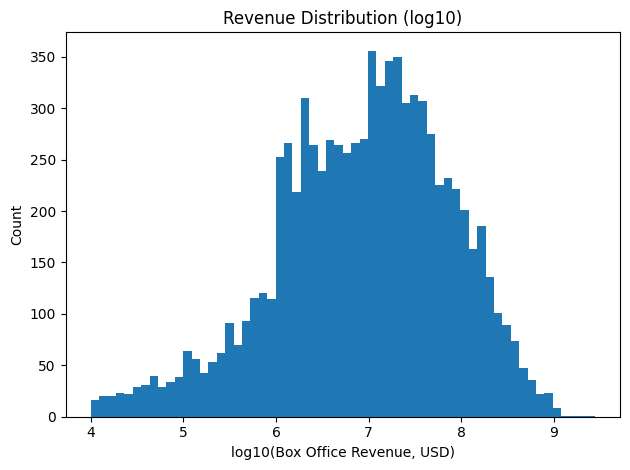

In [ ]:
#  Revenue distribution (log10, valid only)
import matplotlib.pyplot as plt
rev = df["valid_revenue"].dropna()
plt.figure()
np.log10(rev[rev>0]).plot(kind="hist", bins=60)
plt.xlabel("log10(Box Office Revenue, USD)")
plt.ylabel("Count")
plt.title("Revenue Distribution (log10)")
plt.tight_layout()
plt.show()


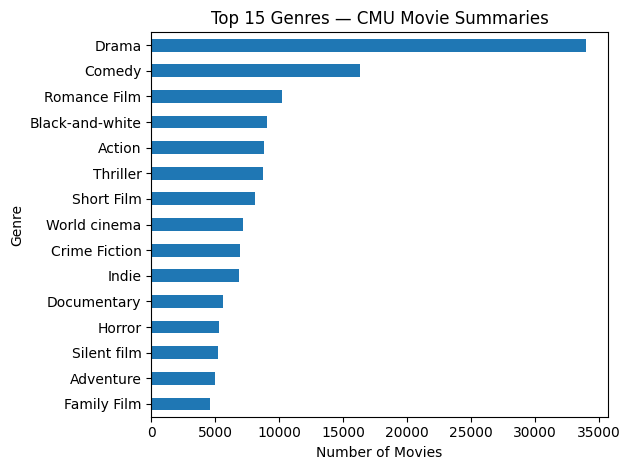

In [ ]:
#  Top 15 genres by movie count
genres_exploded = df.explode("genres_list")
top_genres = (
    genres_exploded["genres_list"]
    .dropna()
    .value_counts()
    .head(15)
    .sort_values(ascending=True)
)
plt.figure()
top_genres.plot(kind="barh")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.title("Top 15 Genres — CMU Movie Summaries")
plt.tight_layout()
plt.show()


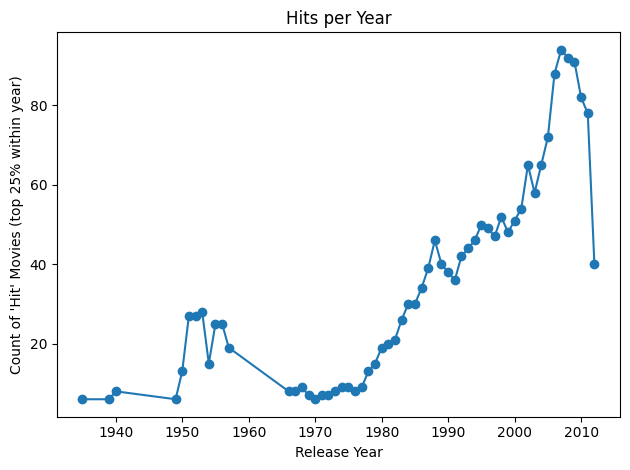

In [ ]:
#  Number of 'hits' per year
hits_per_year = (
    df.loc[df["tier"]=="hit"]
      .groupby(df["release_year"].astype("Int64"))
      .size()
      .rename("hits")
      .sort_index()
)
plt.figure()
hits_per_year.plot(kind="line", marker="o")
plt.xlabel("Release Year")
plt.ylabel("Count of 'Hit' Movies (top 25% within year)")
plt.title("Hits per Year")
plt.tight_layout()
plt.show()


#  Data Preparation & Evaluation Setup

In this step, we prepare the data for machine learning and define a standardized evaluation function to ensure fair comparison across all models.

### Key Steps:
1.  **Cleaning:** We remove rows where the target `tier` is "unknown" or missing (`NaN`), and drop rows with missing `release_year`.
2.  **Feature Engineering:**
    * **Genres:** Converted from lists (e.g., `['Action', 'Comedy']`) to numerical columns using One-Hot Encoding (`MultiLabelBinarizer`).
    * **Scaling:** Numerical features (`movie_runtime`, `release_year`) are scaled using `StandardScaler`. This is critical for models like Logistic Regression to perform well.
3.  **Imputation:** Missing `movie_runtime` values are filled with the median to prevent errors.
4.  **Splitting:** Data is split into Training (80%) and Testing (20%) sets using stratified sampling to maintain class balance (ensuring the "Hit" ratio is the same in both sets).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, label_binarize, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, accuracy_score, f1_score

# --- DATA CLEANING ---
# Ensure we work with a clean copy of the original dataframe
if 'df' in locals():
    # Drop rows where target or year is NaN (fixes 'Input contains NaN' error)
    model_df = df.dropna(subset=['tier', 'release_year']).copy()
    # Filter out the "unknown" class which isn't useful for prediction
    model_df = model_df[model_df['tier'] != 'unknown']

    print(f"Data available for modeling: {model_df.shape[0]} movies")

    # --- FEATURE ENGINEERING ---
    # 1. Encode Genres (Multi-Label Categorical)
    mlb = MultiLabelBinarizer()
    genres_encoded = mlb.fit_transform(model_df['genres_list'])
    genre_df = pd.DataFrame(genres_encoded, columns=mlb.classes_, index=model_df.index)

    # 2. Process Numerical Features
    X_numerical = model_df[['movie_runtime', 'release_year']].copy()

    # Impute missing values for runtime (fill with median)
    imputer = SimpleImputer(strategy='median')
    X_numerical['movie_runtime'] = imputer.fit_transform(X_numerical[['movie_runtime']])

    # Scale numerical features (Crucial for Logistic Regression)
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_numerical)
    X_numerical = pd.DataFrame(X_num_scaled, columns=X_numerical.columns, index=X_numerical.index)

    # 3. Combine Features
    # Reset index to ensure alignment during concatenation
    X_numerical.reset_index(drop=True, inplace=True)
    genre_df.reset_index(drop=True, inplace=True)
    X = pd.concat([X_numerical, genre_df], axis=1)

    # 4. Set Target
    y = model_df['tier'].reset_index(drop=True)

    # --- TRAIN-TEST SPLIT ---
    # Stratify=y ensures we have the same proportion of hits/flops in train and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training Shape: {X_train.shape}")
    print(f"Testing Shape:  {X_test.shape}")
else:
    print("Error: DataFrame 'df' not found. Please run data loading cells first.")

# --- HELPER FUNCTION FOR METRICS ---
def evaluate_model(model, X_test, y_test, model_name):
    """
    Calculates Accuracy, F1-Score, ROC-AUC and plots Confusion Matrix & ROC Curve.
    Returns a dictionary of metrics for comparison.
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    classes = model.classes_

    # 1. Basic Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    try:
        roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
    except:
        roc_auc = 0.5 # Fallback

    print(f"\n=== {model_name} PERFORMANCE ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # 2. Plotting
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(ax=ax[0], cmap='Blues', colorbar=False)
    ax[0].set_title(f"Confusion Matrix: {model_name}")

    # ROC Curve
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = y_test_bin.shape[1]
    colors = ['blue', 'darkorange', 'green']

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_val = auc(fpr, tpr)
        ax[1].plot(fpr, tpr, color=colors[i], lw=2, label=f'{classes[i]} (AUC = {roc_val:.2f})')

    ax[1].plot([0, 1], [0, 1], 'k--', lw=2)
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title(f"ROC Curve: {model_name}")
    ax[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

    return {'Model': model_name, 'Accuracy': acc, 'F1-Score': f1, 'ROC-AUC': roc_auc}

# List to store results
results_list = []

Data available for modeling: 7973 movies
Training Shape: (6378, 309)
Testing Shape:  (1595, 309)


#  Model 1: Random Forest Classifier

We train a **Random Forest Classifier** as our first model.

### Objectives:
* **Establish Baseline:** See how well a standard ensemble method performs.
* **Feature Importance:** Extract the most influential features to answer **Research Question 2** ("What minimal feature subset is near-optimal?"). We visualize which metadata features (e.g., specific genres or runtime) drive box office success.


=== Random Forest PERFORMANCE ===
Accuracy: 0.5423
Weighted F1-Score: 0.5269
ROC-AUC Score: 0.6847

Classification Report:
               precision    recall  f1-score   support

     average       0.54      0.72      0.62       793
        flop       0.54      0.37      0.44       399
         hit       0.55      0.35      0.43       403

    accuracy                           0.54      1595
   macro avg       0.54      0.48      0.50      1595
weighted avg       0.54      0.54      0.53      1595



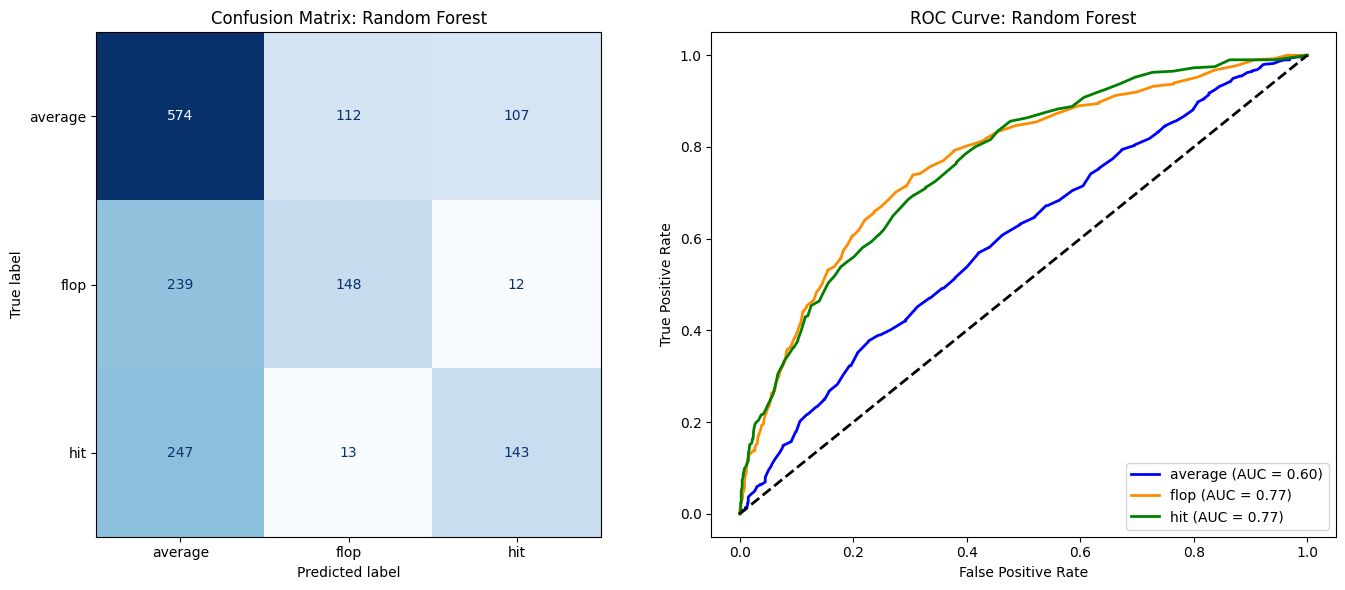

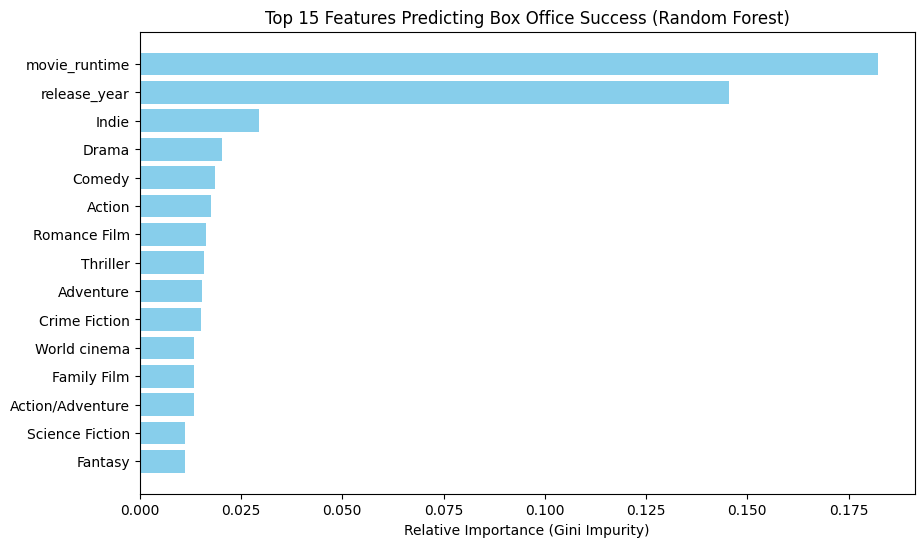

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 1. Train Model
# class_weight='balanced' helps with the imbalance between hits/flops and average movies
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# 2. Evaluate using helper function
rf_results = evaluate_model(rf_model, X_test, y_test, "Random Forest")
results_list.append(rf_results)

# 3. Feature Importance (Specific to Random Forest)
importances = rf_model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
top_features = feature_imp_df.sort_values(by='Importance', ascending=False).head(15)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 15 Features Predicting Box Office Success (Random Forest)")
plt.xlabel("Relative Importance (Gini Impurity)")
plt.show()

 ## Model 2: Gradient Boosting Classifier

We train a **Gradient Boosting Classifier** to attempt to improve upon the Random Forest's performance.

### Objectives:
* **Improve Accuracy:** Gradient Boosting builds trees sequentially, where each new tree corrects the errors of the previous ones. This often yields higher accuracy on tabular data.
* **ROC Analysis:** We focus on the ROC Curves (One-vs-Rest) to visualize how well the model distinguishes specific classes (e.g., "Hit") from the rest. A higher AUC (Area Under Curve) indicates better separation.


=== Gradient Boosting PERFORMANCE ===
Accuracy: 0.5668
Weighted F1-Score: 0.5363
ROC-AUC Score: 0.6904

Classification Report:
               precision    recall  f1-score   support

     average       0.55      0.82      0.66       793
        flop       0.58      0.30      0.40       399
         hit       0.65      0.32      0.43       403

    accuracy                           0.57      1595
   macro avg       0.59      0.48      0.50      1595
weighted avg       0.58      0.57      0.54      1595



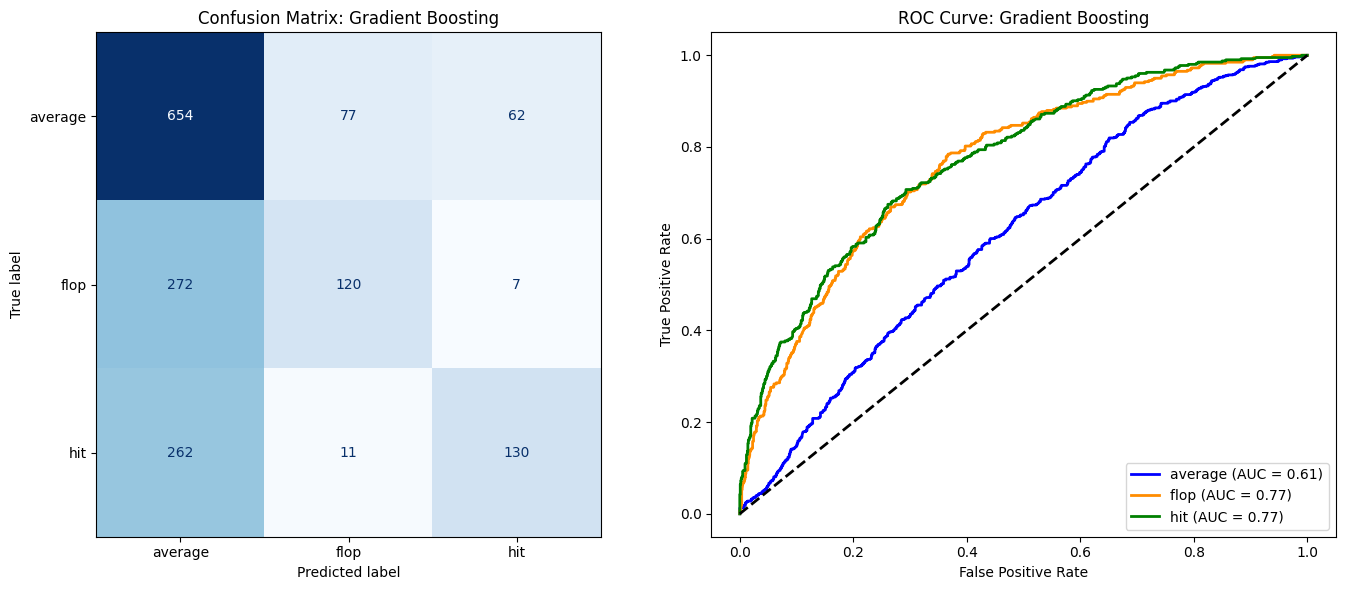

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# 1. Train Model
# learning_rate=0.1 and max_depth=3 are standard starting points for boosting
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# 2. Evaluate using helper function
gb_results = evaluate_model(gb_model, X_test, y_test, "Gradient Boosting")
results_list.append(gb_results)

# 4. Model 3: Logistic Regression

We train a **Logistic Regression** model as a linear baseline.

### Objectives:
* **Complexity Check:** If this simple, linear model performs as well as the complex tree models (Random Forest/Gradient Boosting), it suggests the relationship between metadata and revenue is linear. If it performs poorly, it confirms we need complex non-linear models.
* **Configuration:** We use `multi_class='multinomial'` to handle our three distinct target classes (Hit, Average, Flop).

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== Logistic Regression PERFORMANCE ===
Accuracy: 0.5649
Weighted F1-Score: 0.5425
ROC-AUC Score: 0.6939

Classification Report:
               precision    recall  f1-score   support

     average       0.56      0.79      0.65       793
        flop       0.59      0.34      0.43       399
         hit       0.59      0.35      0.44       403

    accuracy                           0.56      1595
   macro avg       0.58      0.49      0.51      1595
weighted avg       0.57      0.56      0.54      1595



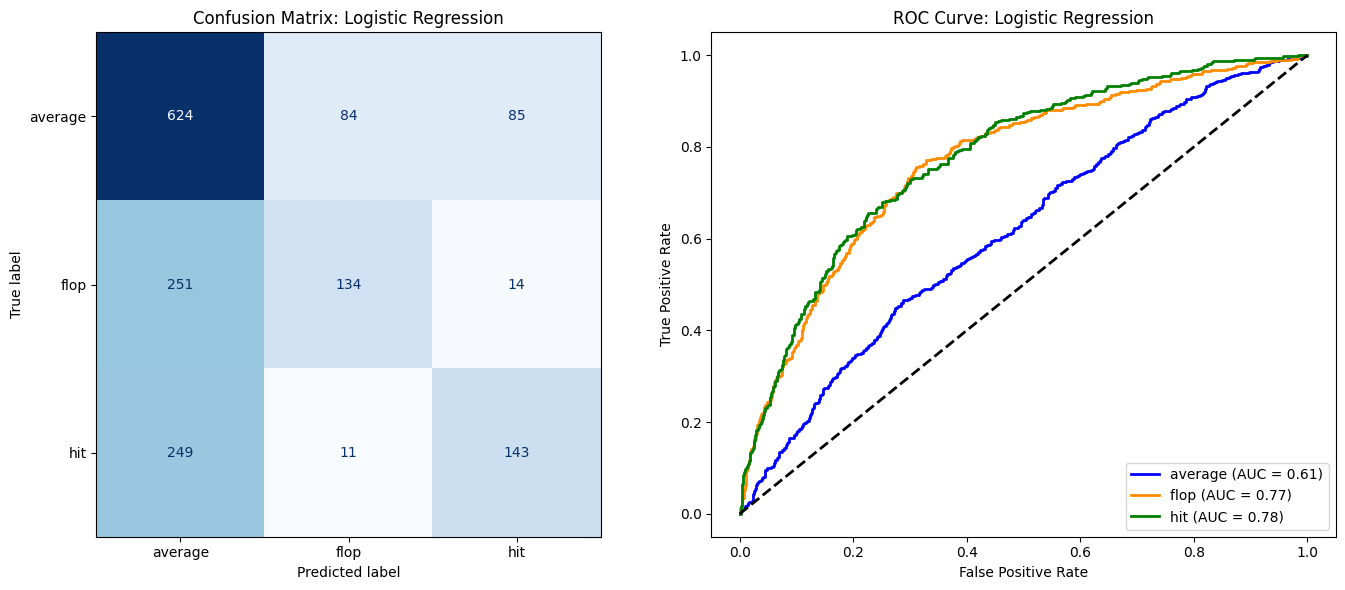

In [ ]:
from sklearn.linear_model import LogisticRegression

# 1. Train Model
# max_iter=1000 ensures the solver has enough time to converge
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# 2. Evaluate using helper function
lr_results = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")
results_list.append(lr_results)

#  Final Model Comparison

We aggregate the metrics from all three models into a single table and chart to answer: **Which model is best?**

### Metrics Used:
* **Accuracy:** The overall percentage of correct predictions.
* **F1-Score (Weighted):** A balanced metric of precision and recall. This is often more important than accuracy for imbalanced datasets.
* **ROC-AUC:** Measures the model's ability to rank classes correctly. A score of 1.0 is perfect; 0.5 is random guessing.

--- FINAL PERFORMANCE COMPARISON ---
                     Accuracy  F1-Score   ROC-AUC
Model                                            
Random Forest        0.542320  0.526873  0.684658
Gradient Boosting    0.566771  0.536306  0.690399
Logistic Regression  0.564890  0.542461  0.693924


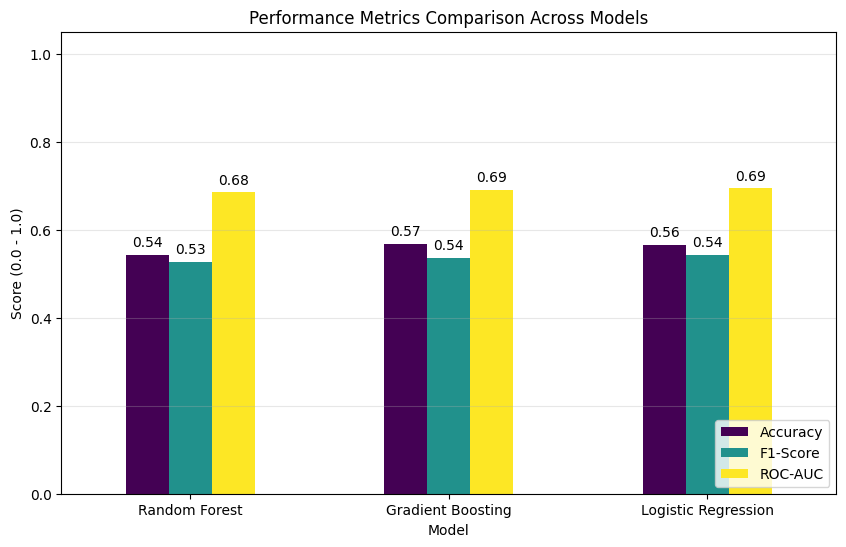

In [ ]:
# Create Comparison DataFrame from the results list
comparison_df = pd.DataFrame(results_list).set_index('Model')

print("--- FINAL PERFORMANCE COMPARISON ---")
print(comparison_df)

# Plot Comparison Bar Chart
ax = comparison_df[['Accuracy', 'F1-Score', 'ROC-AUC']].plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Performance Metrics Comparison Across Models")
plt.ylabel("Score (0.0 - 1.0)")
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.show()

#  Advanced Data Preparation & Feature Engineering

To improve accuracy, we are adding a new source of information: **Movie Titles**.
* **TF-IDF Vectorization:** We convert movie titles into numerical features. Words like "Star", "War", "Love", or "Dead" might carry predictive weight.
* **Feature Stacking:** We combine these new text features with our existing Metadata (Runtime, Year) and Genre features.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack # Efficiently combine sparse matrices


model_df = df.dropna(subset=['tier', 'release_year']).copy()
model_df = model_df[model_df['tier'] != 'unknown']

print(f"Data available: {model_df.shape[0]} movies")

# --- FEATURE 1: GENRES ---
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(model_df['genres_list'])
# Keep as sparse matrix to save memory
from scipy import sparse
X_genres = sparse.csr_matrix(genres_encoded)

# --- FEATURE 2: NUMERICAL (Scaled) ---
X_numerical = model_df[['movie_runtime', 'release_year']].copy()
imputer = SimpleImputer(strategy='median')
X_numerical['movie_runtime'] = imputer.fit_transform(X_numerical[['movie_runtime']])

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_numerical)
X_num_sparse = sparse.csr_matrix(X_num_scaled)

# --- FEATURE 3: TEXT (Movie Titles) ---
# Convert titles to string, handle missing
titles = model_df['movie_name'].fillna('').astype(str)
# limit to top 500 most important words to prevent overfitting
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
X_text = tfidf.fit_transform(titles)

# --- COMBINE ALL FEATURES ---
# We use hstack (horizontal stack) for efficient sparse matrix combination
X_final = hstack([X_num_sparse, X_genres, X_text])

# Target
y = model_df['tier'].reset_index(drop=True)

# --- SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Final Training Shape: {X_train.shape}")
print(f"Final Testing Shape:  {X_test.shape}")
print("Features included: Runtime, Year, Genres, Title (TF-IDF)")


Data available: 7973 movies
Final Training Shape: (6378, 809)
Final Testing Shape:  (1595, 809)
Features included: Runtime, Year, Genres, Title (TF-IDF)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 1. Define the parameter grid to search
param_dist = {
    'n_estimators': [100, 200, 300],        # Number of trees
    'max_depth': [10, 20, 30, None],        # Max depth of trees
    'min_samples_split': [2, 5, 10],        # Min samples to split a node
    'class_weight': ['balanced', None]      # Handle class imbalance
}

# 2. Initialize Model
rf = RandomForestClassifier(random_state=42)

# 3. Setup Randomized Search
# n_iter=10 means we try 10 random combinations (faster than checking all)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,           # 3-fold cross-validation
    verbose=1,
    random_state=42,
    n_jobs=-1       # Use all CPU cores
)

# 4. Train (Fit)
print("Tuning Random Forest parameters...")
random_search.fit(X_train, y_train)

# 5. Best Results
best_rf = random_search.best_estimator_
print(f"Best Parameters found: {random_search.best_params_}")

# 6. Evaluate
y_pred_tuned = best_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred_tuned)
print(f"\nOptimized Random Forest Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred_tuned))

Tuning Random Forest parameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters found: {'n_estimators': 200, 'min_samples_split': 2, 'max_depth': None, 'class_weight': 'balanced'}

Optimized Random Forest Accuracy: 0.5392
              precision    recall  f1-score   support

     average       0.54      0.74      0.62       793
        flop       0.54      0.35      0.42       399
         hit       0.55      0.33      0.41       403

    accuracy                           0.54      1595
   macro avg       0.54      0.47      0.49      1595
weighted avg       0.54      0.54      0.52      1595



Number of unique primary genres: 125
Training Shape: (6378, 3)
Using Features: Runtime, Release Year, Primary Genre (Label Encoded)

Training XGBoost Classifier...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [16:09:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Accuracy: 0.5266
              precision    recall  f1-score   support

     average       0.53      0.82      0.64       793
        flop       0.48      0.22      0.30       399
         hit       0.58      0.25      0.35       403

    accuracy                           0.53      1595
   macro avg       0.53      0.43      0.43      1595
weighted avg       0.53      0.53      0.48      1595



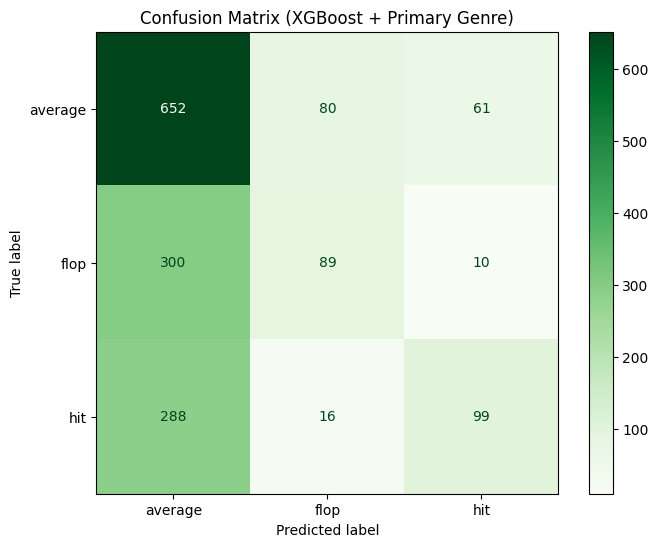

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

# --- STEP 1: DATA PREP (With "Primary Genre" Strategy) ---

if 'df' in locals():
    # 1. Clean Data
    model_df = df.dropna(subset=['tier', 'release_year']).copy()
    model_df = model_df[model_df['tier'] != 'unknown']

    # 2. FEATURE ENGINEERING: Primary Genre
    # Instead of MultiLabelBinarizer, we take the FIRST genre as the "Primary" one.
    # This allows us to use LabelEncoder as you asked.
    model_df['primary_genre'] = model_df['genres_list'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else 'Unknown')

    # Label Encode the Primary Genre
    le = LabelEncoder()
    model_df['primary_genre_encoded'] = le.fit_transform(model_df['primary_genre'])

    print(f"Number of unique primary genres: {len(le.classes_)}")

    # 3. Numerical Features
    X_numerical = model_df[['movie_runtime', 'release_year']].copy()
    imputer = SimpleImputer(strategy='median')
    X_numerical['movie_runtime'] = imputer.fit_transform(X_numerical[['movie_runtime']])

    # 4. Combine Features (Notice how much simpler X is now)
    # We use the encoded genre column + runtime + year
    X = pd.concat([
        X_numerical.reset_index(drop=True),
        model_df['primary_genre_encoded'].reset_index(drop=True)
    ], axis=1)

    # 5. Encode Target (XGBoost requires targets to be integers 0, 1, 2)
    target_le = LabelEncoder()
    y = target_le.fit_transform(model_df['tier'])

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training Shape: {X_train.shape}")
    print("Using Features: Runtime, Release Year, Primary Genre (Label Encoded)")

    # --- STEP 2: TRAIN XGBOOST MODEL ---
    print("\nTraining XGBoost Classifier...")

    # XGBoost is often stronger than Random Forest for tabular data
    model = XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=4,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )

    model.fit(X_train, y_train)

    # --- STEP 3: EVALUATE ---
    y_pred = model.predict(X_test)

    # Inverse transform y_test and y_pred to get original labels (hit/flop/average) back
    y_test_labels = target_le.inverse_transform(y_test)
    y_pred_labels = target_le.inverse_transform(y_pred)

    print(f"\nAccuracy: {accuracy_score(y_test_labels, y_pred_labels):.4f}")
    print(classification_report(y_test_labels, y_pred_labels))

    # Confusion Matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=target_le.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_le.classes_)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, cmap='Greens')
    plt.title("Confusion Matrix (XGBoost + Primary Genre)")
    plt.show()

else:
    print("Error: DataFrame 'df' not found. Please run data loading cells first.")